             rowid          toi       toipfx           tid    ctoi_alias  \
count  7208.000000  7208.000000  7208.000000  7.208000e+03  7.208000e+03   
mean   3604.500000  3516.478153  3516.467675  2.448068e+08  2.448068e+08   
std    2080.914703  2015.275862  2015.276211  1.635215e+08  1.635215e+08   
min       1.000000   101.010000   101.000000  2.876000e+03  2.876010e+03   
25%    1802.750000  1757.017500  1757.000000  1.303101e+08  1.303101e+08   
50%    3604.500000  3496.510000  3496.500000  2.454859e+08  2.454859e+08   
75%    5406.250000  5266.260000  5266.250000  3.531660e+08  3.531660e+08   
max    7208.000000  7036.010000  7036.000000  2.041563e+09  2.041563e+09   

           pl_pnum           ra          dec      st_pmra     st_pmdec  ...  \
count  7208.000000  7208.000000  7208.000000  7089.000000  7089.000000  ...   
mean      1.048002   173.964749    -0.628586    -0.871505    -9.110397  ...   
std       0.265335   101.328270    47.870873    78.835165    68.209524  ...   

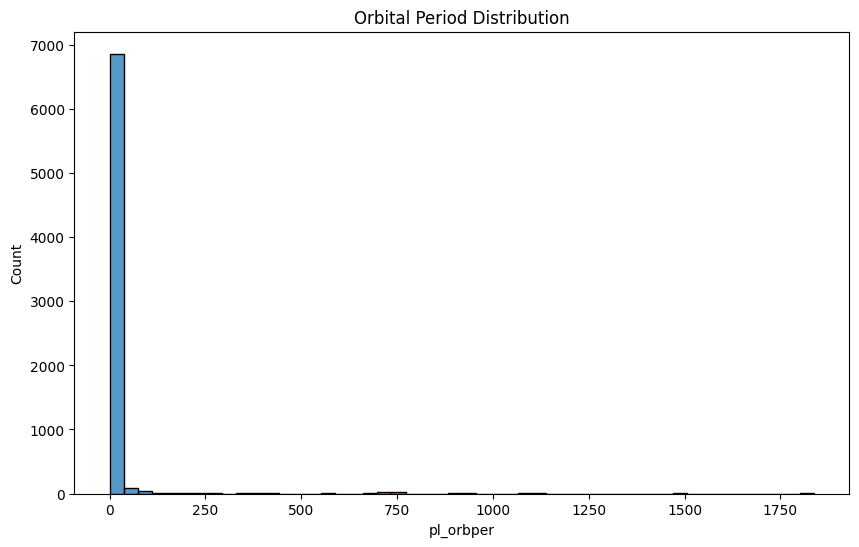

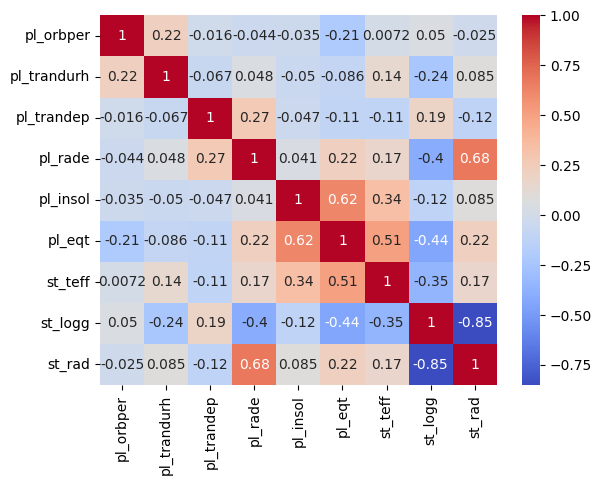

In [10]:
# Cell: Basic analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/TESS exoplanet data.csv")

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize distributions (e.g., orbital period, planetary radius)
plt.figure(figsize=(10, 6))
sns.histplot(df['pl_orbper'].dropna(), bins=50)
plt.title('Orbital Period Distribution')
plt.show()

# Correlation heatmap for key features
key_features = ['pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad']
corr = df[key_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

tfopwg_disp
PC     4641
FP     1044
KP      537
CP      460
APC     425
FA       94
Name: count, dtype: int64


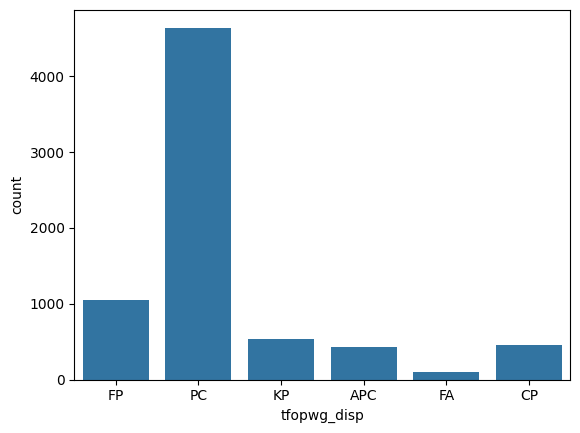

In [11]:
print(df['tfopwg_disp'].value_counts())
sns.countplot(x="tfopwg_disp", data=df)
plt.show()


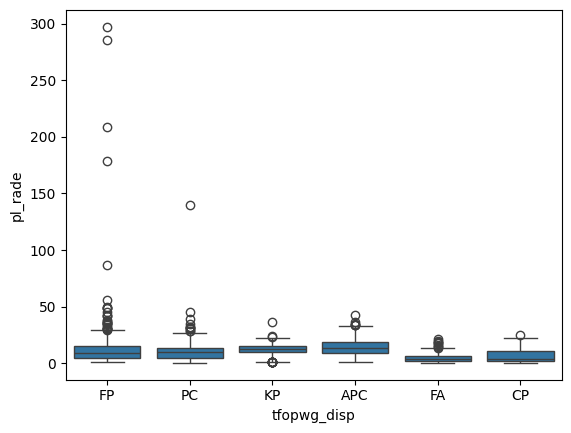

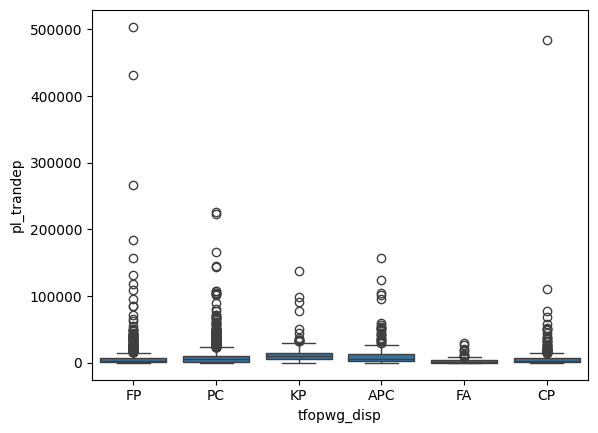

In [12]:
sns.boxplot(x="tfopwg_disp", y="pl_rade", data=df)
plt.show()

sns.boxplot(x="tfopwg_disp", y="pl_trandep", data=df)
plt.show()


In [13]:
# Add this as a new cell after the existing analysis cells

# Cell: Feature Cleaning
from sklearn.preprocessing import LabelEncoder

# Drop ID columns
df_clean = df.drop(columns=['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'toi_created', 'rowupdate'])

# Drop redundant categorical columns (rastr, decstr are strings for ra, dec)
df_clean = df_clean.drop(columns=['rastr', 'decstr'])

# Handle missing values: Impute numerical with median
numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
df_clean[numerical_cols] = df_clean[numerical_cols].fillna(df_clean[numerical_cols].median())

# Encode target (tfopwg_disp) as integers
le = LabelEncoder()
df_clean['tfopwg_disp_encoded'] = le.fit_transform(df_clean['tfopwg_disp'].fillna('Unknown'))  # Handle any remaining NaN in target

# Optional: Check cleaned data
print(df_clean.head())
print(df_clean.isnull().sum())

   pl_pnum tfopwg_disp          ra        dec  st_pmra  st_pmdec  \
0        1          FP  112.357708 -12.695960   -5.964    -0.076   
1        1          PC  122.580465  -5.513852   -4.956   -15.555   
2        1          FP  104.726966 -10.580455   -1.462    -2.249   
3        1          FP  110.559945 -25.207017   -0.939     1.640   
4        1          FP  122.178195 -48.802811   -4.496     9.347   

     pl_tranmid  pl_orbper  pl_trandurh   pl_trandep    pl_rade      pl_insol  \
0  2.459230e+06   2.171348      2.01722   656.886099   5.818163  22601.948581   
1  2.459988e+06   1.931646      3.16600  1286.000000  11.215400  44464.500000   
2  2.459225e+06   1.867557      1.40800  1500.000000  23.752900   2860.610000   
3  2.458493e+06   2.743230      3.16700   383.410000  10.509315   1177.360000   
4  2.459987e+06   3.573014      3.37000   755.000000  11.311300  54679.300000   

        pl_eqt   st_tmag   st_dist  st_teff  st_logg   st_rad  \
0  3127.204052  9.604000   485.735  102

In [14]:
# Add this as a new cell after the feature cleaning cell

# Cell: Feature Engineering and Scaling
import numpy as np
from sklearn.preprocessing import StandardScaler

# Select key astrophysical features
key_features = [
    'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt',  # Planet
    'st_teff', 'st_logg', 'st_rad'  # Star
]
df_selected = df_clean[key_features + ['tfopwg_disp_encoded']]

# Drop columns with excessive missingness (e.g., if >50% missing, but none here exceed that)
# All selected features have <10% missing after imputation

# Log-transform skewed features
df_selected['pl_orbper_log'] = np.log(df_selected['pl_orbper'] + 1)
df_selected['pl_trandep_log'] = np.log(df_selected['pl_trandep'] + 1)

# Scale numerical features (use StandardScaler)
scaler = StandardScaler()
numerical_features = df_selected.select_dtypes(include=['float64', 'int64']).columns.drop('tfopwg_disp_encoded')
df_selected[numerical_features] = scaler.fit_transform(df_selected[numerical_features])

# Optional: Check scaled data
print(df_selected.head())

   pl_orbper  pl_trandurh  pl_trandep   pl_rade  pl_insol    pl_eqt   st_teff  \
0  -0.160271    -0.558770   -0.484217 -0.536895  2.026940  2.768992  2.989385   
1  -0.162675     0.063724   -0.443358  0.105637  4.191780  4.143816  0.854484   
2  -0.163318    -0.888889   -0.429459  1.598204  0.072143  1.135908  2.099563   
3  -0.154536     0.064265   -0.501979  0.021579 -0.094533  0.527735 -0.274751   
4  -0.146215     0.174266   -0.477845  0.117054  5.203254  4.465878  2.297675   

    st_logg    st_rad  tfopwg_disp_encoded  pl_orbper_log  pl_trandep_log  
0 -0.411360  0.487928                    3      -0.678527       -1.320414  
1 -0.967408  0.387255                    5      -0.761229       -0.815008  
2  0.075181  2.729943                    3      -0.784488       -0.699158  
3 -0.550372 -0.101819                    3      -0.504068       -1.725108  
4 -0.585125  0.475421                    3      -0.293378       -1.215716  


/tmp/ipykernel_44252/1060374832.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['pl_orbper_log'] = np.log(df_selected['pl_orbper'] + 1)
/tmp/ipykernel_44252/1060374832.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['pl_trandep_log'] = np.log(df_selected['pl_trandep'] + 1)
/tmp/ipykernel_44252/1060374832.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [17]:
# Modify the existing cell to fix the NaN error in y

from sklearn.model_selection import train_test_split

# Use df_clean (from feature cleaning cell) to ensure missing values are handled
# Drop rows where tfopwg_disp is NaN (since stratify requires no NaN in y)
df_clean_no_nan = df_clean.dropna(subset=['tfopwg_disp'])

X = df_clean_no_nan.drop(columns=["tfopwg_disp"])  # Columns already dropped in df_clean
y = df_clean_no_nan["tfopwg_disp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# Modify the existing cell to fix the target_names mismatch

# Cell: Train and Compare Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Use df_selected for features (scaled), align with df_clean_no_nan for y
# Assuming df_selected is filtered to df_clean_no_nan rows
df_selected_no_nan = df_selected.loc[df_clean_no_nan.index]
X = df_selected_no_nan.drop(columns=['tfopwg_disp_encoded'])
y = df_selected_no_nan['tfopwg_disp_encoded']  # Use encoded for models

# Split (reuse from previous cell or recompute)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Models
models = {
    'LogisticRegression': Pipeline([('smote', smote), ('clf', LogisticRegression(multi_class='multinomial', class_weight='balanced', max_iter=1000))]),
    'RandomForest': Pipeline([('smote', smote), ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))]),
    'XGBoost': Pipeline([('smote', smote), ('clf', xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), scale_pos_weight=1, random_state=42))]),
    'LightGBM': Pipeline([('smote', smote), ('clf', lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y)), class_weight='balanced', random_state=42))])
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)  # SMOTE in pipeline
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    labels = np.unique(y_test)
    target_names = le.inverse_transform(labels)
    print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

/home/laksh/Desktop/hackathon/exovision/exo-model/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression Accuracy: 0.2068
              precision    recall  f1-score   support

         APC       0.14      0.45      0.21        85
          CP       0.16      0.46      0.23        92
          FA       0.03      0.32      0.06        19
          FP       0.37      0.25      0.30       209
          KP       0.13      0.52      0.21       107
          PC       0.81      0.11      0.20       929

    accuracy                           0.21      1441
   macro avg       0.27      0.35      0.20      1441
weighted avg       0.60      0.21      0.21      1441

RandomForest Accuracy: 0.5260
              precision    recall  f1-score   support

         APC       0.22      0.33      0.26        85
          CP       0.19      0.27      0.22        92
          FA       0.00      0.00      0.00        19
          FP       0.46      0.49      0.48       209
          KP       0.25      0.36      0.30       107
          PC       0.74      0.61      0.67       929

    accurac

/home/laksh/Desktop/hackathon/exovision/exo-model/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.5274
              precision    recall  f1-score   support

         APC       0.21      0.34      0.26        85
          CP       0.21      0.35      0.27        92
          FA       0.02      0.05      0.03        19
          FP       0.50      0.50      0.50       209
          KP       0.26      0.38      0.31       107
          PC       0.75      0.59      0.66       929

    accuracy                           0.53      1441
   macro avg       0.33      0.37      0.34      1441
weighted avg       0.60      0.53      0.56      1441

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 22272, number of used features: 11
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training fr

In [21]:
# Add this as a new cell after the model comparison cell

# Cell: Hyper-tune XGBoost and Save Best Model
from sklearn.model_selection import GridSearchCV
import joblib

# Define parameter grid for XGBoost
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.1, 0.2],
    'clf__subsample': [0.8, 1.0]
}

# Create pipeline with SMOTE
pipeline = Pipeline([('smote', smote), ('clf', xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), random_state=42))])

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
labels = np.unique(y_test)
target_names = le.inverse_transform(labels)
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

# Save best model, scaler, and label encoder
joblib.dump(best_model, 'models/tess_xgb_model.pkl')
joblib.dump(scaler, 'models/tess_scaler.pkl')
joblib.dump(le, 'models/tess_label_encoder.pkl')

print("Best model saved as tess_xgb_model.pkl")

Best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best CV accuracy: 0.5535
Test Accuracy: 0.5663
              precision    recall  f1-score   support

         APC       0.18      0.21      0.20        85
          CP       0.22      0.25      0.23        92
          FA       0.00      0.00      0.00        19
          FP       0.46      0.46      0.46       209
          KP       0.28      0.32      0.30       107
          PC       0.74      0.69      0.72       929

    accuracy                           0.57      1441
   macro avg       0.31      0.32      0.32      1441
weighted avg       0.59      0.57      0.58      1441

Best model saved as tess_xgb_model.pkl


In [22]:
# Add this as a new cell after the hyper-tuning cell

# Cell: Further Hyper-tune XGBoost with RandomizedSearchCV and Early Stopping
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Expanded parameter distribution
param_dist = {
    'clf__n_estimators': [200, 300, 400],
    'clf__max_depth': [6, 9, 12, 15],
    'clf__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'clf__subsample': [0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.8, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.2],
    'clf__min_child_weight': [1, 3, 5]
}

# Create pipeline with SMOTE
pipeline = Pipeline([('smote', smote), ('clf', xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), random_state=42))])

# Randomized search with early stopping (using eval_set)
# Note: For early stopping, we need to fit with eval_set; RandomizedSearchCV supports it via fit_params
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit with early stopping (XGBoost needs eval_set)
# We need to pass eval_set to the clf step
# Modify pipeline to include early_stopping_rounds in clf
pipeline_early = Pipeline([('smote', smote), ('clf', xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), random_state=42, early_stopping_rounds=10))])

random_search = RandomizedSearchCV(pipeline_early, param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# For early stopping, we need to provide eval_set during fit
# RandomizedSearchCV can take fit_params
fit_params = {'clf__eval_set': [(X_test, y_test)]}

random_search.fit(X_train, y_train, **fit_params)

# Best model
improved_model = random_search.best_estimator_
print(f"Improved Best params: {random_search.best_params_}")
print(f"Improved CV accuracy: {random_search.best_score_:.4f}")

# Evaluate on test set
y_pred_improved = improved_model.predict(X_test)
print(f"Improved Test Accuracy: {accuracy_score(y_test, y_pred_improved):.4f}")
labels = np.unique(y_test)
target_names = le.inverse_transform(labels)
print(classification_report(y_test, y_pred_improved, labels=labels, target_names=target_names))

# Save improved model
joblib.dump(improved_model, 'models/tess_xgb_improved_model.pkl')
print("Improved model saved as tess_xgb_improved_model.pkl")

[0]	validation_0-mlogloss:1.75192
[0]	validation_0-mlogloss:1.75692
[0]	validation_0-mlogloss:1.75649
[1]	validation_0-mlogloss:1.71634
[0]	validation_0-mlogloss:1.71840
[0]	validation_0-mlogloss:1.75716
[1]	validation_0-mlogloss:1.72244
[1]	validation_0-mlogloss:1.72435
[2]	validation_0-mlogloss:1.68804
[0]	validation_0-mlogloss:1.75294
[0]	validation_0-mlogloss:1.65666
[0]	validation_0-mlogloss:1.63921
[1]	validation_0-mlogloss:1.72403
[1]	validation_0-mlogloss:1.66281
[0]	validation_0-mlogloss:1.72835
[2]	validation_0-mlogloss:1.69577
[3]	validation_0-mlogloss:1.66386
[2]	validation_0-mlogloss:1.69386
[1]	validation_0-mlogloss:1.71608
[0]	validation_0-mlogloss:1.63478
[2]	validation_0-mlogloss:1.69752
[1]	validation_0-mlogloss:1.67042
[3]	validation_0-mlogloss:1.66991
[4]	validation_0-mlogloss:1.63884
[0]	validation_0-mlogloss:1.64030
[2]	validation_0-mlogloss:1.68604
[2]	validation_0-mlogloss:1.61865
[0]	validation_0-mlogloss:1.64398
[3]	validation_0-mlogloss:1.67237
[3]	validation